# Benchmarking TiTiler-CMR Tiles API Endpoints

This notebook walks you through a workflow to **benchmark performance** of a [TiTiler-CMR](https://github.com/developmentseed/titiler-cmr) deployment for a given Earthdata CMR dataset.

This notebook benchmarks tiling [GPM IMERG Final Precipitation L3 1 day 0.1 degree x 0.1 degree V07 (GPM_3IMERGDF) at GES DISC](https://data.nasa.gov/dataset/gpm-imerg-final-precipitation-l3-1-day-0-1-degree-x-0-1-degree-v07-gpm-3imergdf-at-ges-dis-13ed8) as an example using the titiler-cmr `xarray` backend and [HLS Sentinel-2 Multi-spectral Instrument Surface Reflectance Daily Global 30m v2.0](https://www.earthdata.nasa.gov/data/catalog/lpcloud-hlss30-2.0) as an example using the titiler-cmr `rasterio` backend.


> **What is TiTiler-CMR?**
>
> [TiTiler](https://github.com/developmentseed/titiler) is a lightweight dynamic tiling server for raster/COG data.
> 
> **TiTiler-CMR** is a variant/deployment that integrates with NASA's **Common Metadata Repository (CMR)** so you can render tiles **directly from CMR-managed datasets** (e.g., HDF5/NetCDF4/GRIB hosted on Earthdata Cloud).
> It can resolve a **CMR concept ID** to a renderable item, and expose tile and statistics endpoints without you needing to manually construct source URLs.

-----------------------------------

**In this notebook, you'll learn**:

- How to benchmark tile rendering performance across zoom levels
- What factors impact tile generation performance in TiTiler-CMR for different backends (e.g., NetCDF4 vs rasterio/GDAL)

In [3]:
import asyncio
import pandas as pd

from datacube_benchmark.titiler import (
    DatasetParams,
    benchmark_viewport,
    tiling_benchmark_summary,
)
from datacube_benchmark.titiler.cmr.benchmark import check_titiler_cmr_compatibility

## TiTiler-CMR Setup

`titiler-cmr` is a NASA-focused application that accepts Concept IDs and uses the Common Metadata Repository (CMR) to discover and serve associated granules as tiles. You can deploy your own instance of `titiler-cmr` using the [official guide](https://github.com/developmentseed/titiler-cmr), or use an existing deployment.

For this walkthrough, we will use the [Open VEDA](https://www.earthdata.nasa.gov/data/tools/veda) deployment: [https://staging.openveda.cloud/api/titiler-cmr/](https://staging.openveda.cloud/api/titiler-cmr/).

To get started with a dataset, you need to:
- Choose a Titiler-CMR endpoint
- Pick a CMR dataset (by concept ID)

For the following, you Can use titiler-cmr's compatibility endpoint [ADD LINK TO DOCS ONCE https://github.com/developmentseed/titiler-cmr/pull/80 IS MERGED]:
- Identify the assets/variables/bands you want to visualize
- Define a temporal interval (`start/end` ISO range) and, if needed, a time step (e.g., daily).
- Select a backend that matches your dataset’s structure

Titiler-CMR supports two different backends:
  - **xarray** → for gridded/cloud-native datasets (e.g., NetCDF4/HDF5/GRIB), typically exposed as variables.
  - **rasterio** → for COG/raster imagery-style datasets exposed as bands (optionally via a regex).


> **Tip: Explore data granules with `earthaccess`**
> 
> You can use [`earthaccess`](https://github.com/nsidc/earthaccess) to search and inspect the individual granules used in your query. This helps you validate which files were accessed, their sizes, and the temporal range.

In [ ]:
import earthaccess

concept_id = "C2723754864-GES_DISC"
time_range = ("2022-03-01T00:00:01Z", "2022-03-02T23:59:59Z")

# Authenticate if needed
earthaccess.login()  # or use "interactive" if needed

results = earthaccess.search_data(concept_id=concept_id, temporal=time_range)

print(f"Found {len(results)} granules between {time_range[0]} and {time_range[1]}")

Found 2 granules between 2022-03-01T00:00:01Z and 2022-03-02T23:59:59Z


## Tile Generation Benchmarking

The code below demonstrates how to benchmark tile generation performance across different zoom levels using `titiler_cmr_benchmark.benchmark_viewport` function. 
This function simulates the load of a typical viewport render in a slippy map, where multiple adjacent tiles must be fetched in parallel to draw a single view.


First, we have to define the parameters for the CMR dataset we want to benchmark. The `DatasetParams` class encapsulates all the necessary information to interact with a specific dataset via TiTiler-CMR.


In [ ]:
endpoint = "https://staging.openveda.cloud/api/titiler-cmr"

ds_xarray = DatasetParams(
    # GPM IMERG Final Precipitation L3 1 day 0.1 degree x 0.1 degree V07 (GPM_3IMERGDF) at GES DISC
    concept_id="C2723754864-GES_DISC",
    backend="xarray",
    datetime_range="2022-03-01T00:00:01Z/2022-03-01T23:59:59Z",
    variable="precipitation",
    step="P1D",
    temporal_mode="point",
)

In [ ]:
compat = await check_titiler_cmr_compatibility(
    endpoint=endpoint,
    dataset=ds_xarray,
    timeout_s=250.0,
)

print(f"Compatibility: {compat['compatibility']}")
print(f"Timesteps: {compat['n_timesteps']}")
print(f"Bounds: {compat['tilejson_bounds']}")
if not compat["statistics"].empty:
    print(f"Statistics preview:\n{compat['statistics']}")

=== TiTiler-CMR Compatibility Check ===
Client: 8 physical / 8 logical cores | RAM: 16.00 GiB
Dataset: C2723754864-GES_DISC (xarray)
Found 1 timesteps/granules from TileJSON
Using random bounds for compatibility check: [-55.363307852513095, 37.583182317779745, 25.135139337479337, 77.83240591277595]
Statistics returned 1 timesteps
Compatibility: compatible
Timesteps: 1
Bounds: [-180.0, -90.0, 180.0, 90.0]
Statistics preview:
                       timestamp  min        max      mean      count  \
0  2022-03-01T00:00:00.000000000  0.0  84.825005  3.631561  324133.25   

          sum       std  median  majority  minority   unique  valid_percent  \
0  1177109.75  7.336288    0.35       0.0     0.065  24709.0          100.0   

   masked_pixels  valid_pixels  percentile_2  percentile_98  
0            0.0      325624.0           0.0      28.200001  


### Zoom Levels
Zoom levels determine the detail and extent of the area being rendered. At lower zoom levels, a single tile covers a large spatial area and requires more data be loaded relative to higher zoom levels. Sometimes, data must be loaded from multiple granules. Loading data from multiple granules is not required for the example dataset, as each granule has global coverage. In general, lower zoom levels translates to more I/O, more resampling/mosaic work, higher latency, and higher chance of timeouts errors.

As you increase zoom, each tile covers a smaller area, reducing the amount of work per request. 

We'll define a range of zoom levels to test to see how performance varies.

In [ ]:
min_zoom = 3
max_zoom = 20

# Define the viewport parameters
viewport_width = 4
viewport_height = 4
lng = 25.0
lat = 29.0

Now, let's run the benchmark across the specified zoom levels and visualize the results.

Under the hood, `benchmark_viewport` computes the center tile for each zoom level, selects its neighboring tiles to approximate a viewport, and requests them concurrently from the TiTiler-CMR endpoint. This function returns a pandas.DataFrame containing the response times for each tile request.


In [ ]:
df_viewport = await benchmark_viewport(
    endpoint=endpoint,
    dataset=ds_xarray,
    lng=lng,
    lat=lat,
    viewport_width=viewport_width,
    viewport_height=viewport_height,
    min_zoom=min_zoom,
    max_zoom=max_zoom,
    timeout_s=60.0,
)

=== TiTiler-CMR Tile Benchmark ===
Client: 8 physical / 8 logical cores | RAM: 16.00 GiB
Dataset: C2723754864-GES_DISC (xarray)
Query params: 8 parameters
  concept_id: C2723754864-GES_DISC
  backend: xarray
  datetime: 2022-03-01T00:00:01Z/2022-03-01T23:59:59Z
  variable: precipitation
  step: P1D
  temporal_mode: point
  tile_format: png
  tile_scale: 1
Total execution time: 23.760s


In [ ]:
df_viewport.head()

,zoom,x,y,status_code,ok,no_data,is_error,response_time_sec,content_type,response_size_bytes,url,error_text,total_run_elapsed_s
0,3,2,1,200,True,False,False,0.937998,image/png,694,https://staging.openveda.cloud/api/titiler-cmr...,None,23.760225
1,3,3,1,200,True,False,False,1.573622,image/png,694,https://staging.openveda.cloud/api/titiler-cmr...,None,23.760225
2,3,4,1,200,True,False,False,0.986524,image/png,694,https://staging.openveda.cloud/api/titiler-cmr...,None,23.760225
3,3,5,1,200,True,False,False,0.961534,image/png,694,https://staging.openveda.cloud/api/titiler-cmr...,None,23.760225
4,3,6,1,200,True,False,False,1.155569,image/png,694,https://staging.openveda.cloud/api/titiler-cmr...,None,23.760225


The output includes the following columns:
 
- `zoom, x, y` — XYZ tile indices
- `status_code` — HTTP code (200 = success, 204 = no-data, 4xx/5xx = errors)
- `response_time_sec` — wall time in seconds
- `response_size_bytes` — payload size
- `ok`, `is_error, has_data` — convenience flags

Now, let's use a convenience function to summarize the benchmark results. 

In [ ]:
df_summary = tiling_benchmark_summary(df_viewport)
df_summary

,zoom,n_tiles,ok_pct,no_data_pct,error_pct,median_latency_s,p95_latency_s
0,3,25.0,100.0,0.0,0.0,1.338306,7.174594
1,4,25.0,100.0,0.0,0.0,1.262198,7.091972
2,5,25.0,100.0,0.0,0.0,1.161212,7.161183
3,6,25.0,100.0,0.0,0.0,1.300602,7.068649
4,7,25.0,100.0,0.0,0.0,1.429176,7.127629
5,8,25.0,100.0,0.0,0.0,1.223532,7.166088
6,9,25.0,100.0,0.0,0.0,1.272602,7.019425
7,10,25.0,100.0,0.0,0.0,1.090893,6.192206
8,11,25.0,100.0,0.0,0.0,1.099792,2.061258
9,12,25.0,100.0,0.0,0.0,1.117183,1.945991


We'll now plot the results.

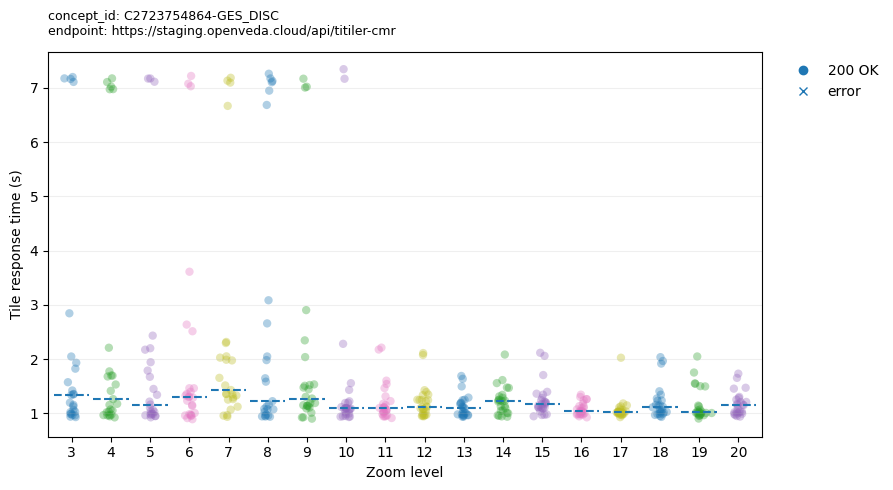

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D


def summarize_and_plot_tiles_from_df(
    df: pd.DataFrame,
    *,
    jitter=0.08,
    alpha=0.35,
    figsize=(9, 5),
    title_lines=None,
):
    summary = tiling_benchmark_summary(df)

    fig, ax = plt.subplots(figsize=figsize)
    fig.subplots_adjust(right=0.72, top=0.80)

    zoom_levels = sorted(
        int(z) for z in pd.to_numeric(df["zoom"], errors="coerce").dropna().unique()
    )
    ax.set_xticks(zoom_levels)
    if zoom_levels:
        ax.set_xlim(min(zoom_levels) - 0.6, max(zoom_levels) + 0.6)

    for z in zoom_levels:
        sub = df[df["zoom"] == z]
        if sub.empty:
            continue

        x = np.random.normal(loc=z, scale=jitter, size=len(sub))
        ok_mask = sub["ok"].astype(bool).values
        err_mask = sub["is_error"].astype(bool).values

        ax.scatter(
            x[ok_mask],
            sub.loc[ok_mask, "response_time_sec"],
            alpha=alpha,
            edgecolor="none",
            label=None,
        )
        ax.scatter(
            x[err_mask],
            sub.loc[err_mask, "response_time_sec"],
            marker="x",
            alpha=min(0.85, alpha + 0.25),
            label=None,
        )

        med = pd.to_numeric(sub["response_time_sec"], errors="coerce").median()
        if np.isfinite(med):
            ax.hlines(med, z - 0.45, z + 0.45, linestyles="--")

    ax.set_xlabel("Zoom level")
    ax.set_ylabel("Tile response time (s)")

    ok_proxy = Line2D([], [], linestyle="none", marker="o", label="200 OK")
    err_proxy = Line2D(
        [], [], linestyle="none", marker="x", label="error (≥400 or failure)"
    )
    ax.legend(
        [ok_proxy, err_proxy],
        ["200 OK", "error"],
        frameon=False,
        loc="upper left",
        bbox_to_anchor=(1.02, 1.00),
    )

    if title_lines:
        ax.set_title("\n".join(title_lines), fontsize=9, loc="left", pad=12)

    ax.grid(True, axis="y", alpha=0.2)
    plt.tight_layout()

    return summary, (fig, ax)


summary, (fig, ax) = summarize_and_plot_tiles_from_df(
    df_viewport,
    title_lines=[
        "concept_id: C2723754864-GES_DISC",
        "endpoint: https://staging.openveda.cloud/api/titiler-cmr",
    ],
)
plt.show()

### Rasterio Backend (COG/Band-based datasets)
In this example, we will benchmark [HLS Sentinel-2 Multi-spectral Instrument Surface Reflectance Daily Global 30m v2.0 (HLS)](https://www.earthdata.nasa.gov/data/catalog/lpcloud-hlss30-2.0). HLS granules are Cloud Optimized GeoTIFFs (COGs) with individual bands. We will use the `rasterio` backend for this dataset.

Since HLS granules each cover a small spatial extent, the lower the zoom level (more zoomed out), the more files need to be opened to render a tile. So lower zoom levels lead to increased latency. Additionally, datasets with larger file sizes or more complex structures may also experience higher latency.

With the `rasterio` backend, each `/tile` request:
- finds all granules intersecting the tile footprint and the selected datetime interval
- reads & mosaics those granules (across space/time), resamples, stacks bands, then encodes the image  

Tile latency depends strongly on the length of the datetime interval and the temporal resolution of the dataset.

In [ ]:
ds_hls_day = DatasetParams(
    concept_id="C2021957295-LPCLOUD",
    backend="rasterio",
    datetime_range="2023-10-01T00:00:01Z/2023-10-07T00:00:01Z",
    bands=["B04", "B03", "B02"],
    bands_regex="B[0-9][0-9]",
    temporal_mode="point",
)
ds_hls_week = DatasetParams(
    concept_id="C2021957657-LPCLOUD",
    backend="rasterio",
    datetime_range="2023-10-01T00:00:01Z/2023-10-20T00:00:01Z",
    bands=["B04", "B03", "B02"],
    bands_regex="B[0-9][0-9]",
    temporal_mode="point",
)

min_zoom = 3
max_zoom = 20
viewport_width = 3
viewport_height = 3
timeout_s = 60.0

In [ ]:
df_viewport_day = await benchmark_viewport(
    endpoint=endpoint,
    dataset=ds_hls_day,
    lng=lng,
    lat=lat,
    viewport_width=viewport_width,
    viewport_height=viewport_height,
    min_zoom=min_zoom,
    max_zoom=max_zoom,
    timeout_s=timeout_s,
)

df_viewport_day_summary = tiling_benchmark_summary(df_viewport_day)
df_viewport_day_summary

=== TiTiler-CMR Tile Benchmark ===
Client: 8 physical / 8 logical cores | RAM: 16.00 GiB
Dataset: C2021957295-LPCLOUD (rasterio)
Query params: 11 parameters
  concept_id: C2021957295-LPCLOUD
  backend: rasterio
  datetime: 2023-10-01T00:00:01Z/2023-10-07T00:00:01Z
  bands: B04
  bands: B03
  bands: B02
  bands_regex: B[0-9][0-9]
  step: P1D
  temporal_mode: point
  tile_format: png
  tile_scale: 1
Total execution time: 37.370s


,zoom,n_tiles,ok_pct,no_data_pct,error_pct,median_latency_s,p95_latency_s
0,3,9.0,100.0,0.0,0.0,23.439638,27.776124
1,4,9.0,100.0,0.0,0.0,19.453822,23.137774
2,5,9.0,100.0,0.0,0.0,19.171042,21.092155
3,6,9.0,100.0,0.0,0.0,13.852990,19.013567
4,7,9.0,100.0,0.0,0.0,6.470076,8.014772
5,8,9.0,100.0,0.0,0.0,2.995943,4.376422
6,9,9.0,100.0,0.0,0.0,1.641083,2.751500
7,10,9.0,100.0,0.0,0.0,2.090352,2.847120
8,11,9.0,100.0,0.0,0.0,2.546253,3.079243
9,12,9.0,100.0,0.0,0.0,1.031531,2.355738


In [ ]:
df_viewport_week = await benchmark_viewport(
    endpoint=endpoint,
    dataset=ds_hls_week,
    lng=lng,
    lat=lat,
    viewport_width=viewport_width,
    viewport_height=viewport_height,
    min_zoom=min_zoom,
    max_zoom=max_zoom,
    timeout_s=timeout_s,
)

df_viewport_week_summary = tiling_benchmark_summary(df_viewport_week)
df_viewport_week_summary

=== TiTiler-CMR Tile Benchmark ===
Client: 2 physical / 4 logical cores | RAM: 30.89 GiB
Dataset: C2021957657-LPCLOUD (rasterio)
Query params: 11 parameters
  concept_id: C2021957657-LPCLOUD
  backend: rasterio
  datetime: 2023-10-01T00:00:01Z/2023-10-20T00:00:01Z
  bands: B04
  bands: B03
  bands: B02
  bands_regex: B[0-9][0-9]
  step: P1W
  temporal_mode: point
  tile_format: png
  tile_scale: 1
Total execution time: 37.966s


,zoom,n_tiles,ok_pct,no_data_pct,error_pct,median_latency_s,p95_latency_s
0,3,9.0,100.0,0.0,0.0,22.926830,24.378291
1,4,9.0,100.0,0.0,0.0,17.921357,18.726973
2,5,9.0,100.0,0.0,0.0,16.929122,17.784730
3,6,9.0,100.0,0.0,0.0,17.537620,19.149198
4,7,9.0,100.0,0.0,0.0,9.616842,12.005472
5,8,9.0,100.0,0.0,0.0,4.761738,5.956546
6,9,9.0,100.0,0.0,0.0,2.060429,3.757879
7,10,9.0,100.0,0.0,0.0,1.500306,2.483718
8,11,9.0,100.0,0.0,0.0,1.194113,2.596202
9,12,9.0,100.0,0.0,0.0,1.121369,1.218752


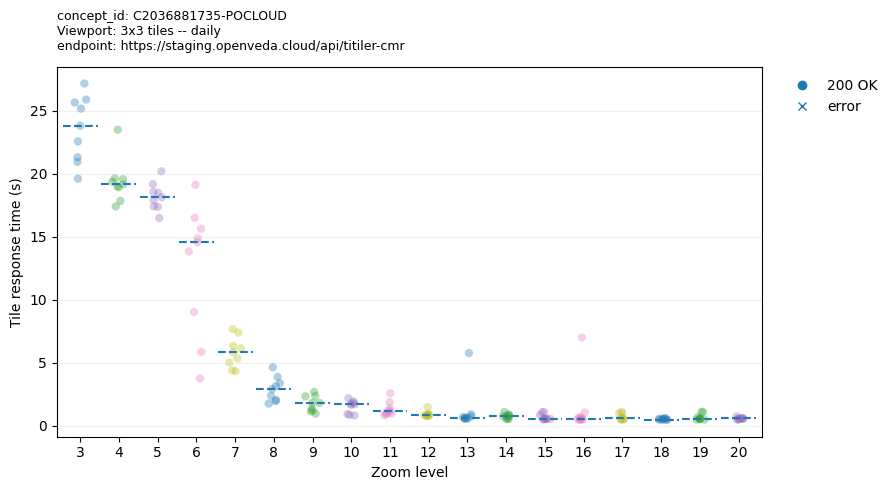

In [ ]:
summary, (fig, ax) = summarize_and_plot_tiles_from_df(
    df_viewport_day,
    title_lines=[
        "concept_id: C2036881735-POCLOUD",
        "Viewport: 3x3 tiles -- daily",
        "endpoint: https://staging.openveda.cloud/api/titiler-cmr",
    ],
)

plt.show()

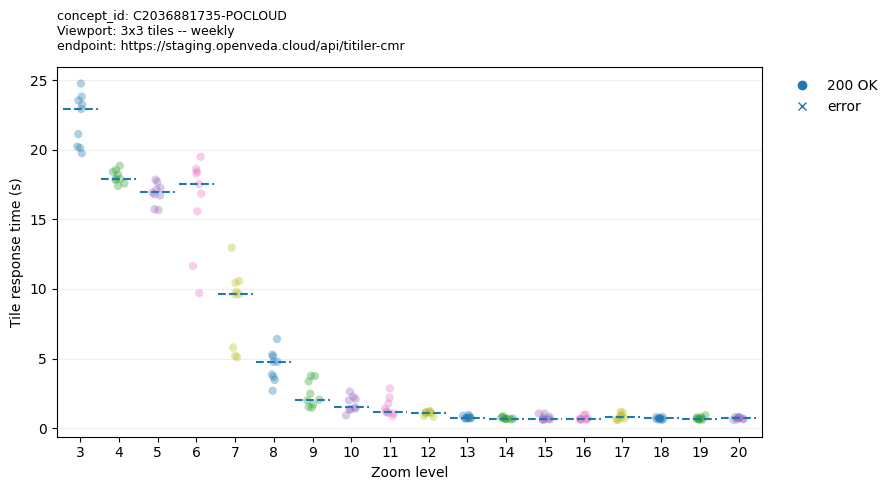

In [ ]:
summary, (fig, ax) = summarize_and_plot_tiles_from_df(
    df_viewport_week,
    title_lines=[
        "concept_id: C2036881735-POCLOUD",
        "Viewport: 3x3 tiles -- weekly",
        "endpoint: https://staging.openveda.cloud/api/titiler-cmr",
    ],
)

plt.show()

## Benchmarking using custom bounds

UPDATE ME

In this part, we are going to measure response latency across the tiles at different zoom levels using `benchmark_viewport` function. 
This function simulates the load of a typical viewport render in a slippy map, where multiple adjacent tiles must be fetched in parallel to draw a single view.

Under the hood, `benchmark_viewport` computes the center tile for each zoom level, selects its neighboring tiles to approximate a viewport, and requests them concurrently from the TiTiler-CMR endpoint. This function returns a pandas DataFrame containing the response times for each tile request.

In [15]:
df_viewport = await benchmark_viewport(
    endpoint=endpoint,
    dataset=ds_xarray,
    lng=-95.0,
    lat=29.0,
    viewport_width=3,
    viewport_height=3,
    min_zoom=7,
    max_zoom=8,
    timeout_s=60.0,
)

df_viewport.head()

=== TiTiler-CMR Tile Benchmark ===
Client: 2 physical / 4 logical cores | RAM: 30.89 GiB
Dataset: C2723754864-GES_DISC (xarray)
Query params: 8 parameters
  concept_id: C2723754864-GES_DISC
  backend: xarray
  datetime: 2022-03-01T00:00:01Z/2022-03-01T23:59:59Z
  variable: precipitation
  step: P1D
  temporal_mode: point
  tile_format: png
  tile_scale: 1
Total execution time: 1.291s


,zoom,x,y,status_code,ok,no_data,is_error,response_time_sec,content_type,response_size_bytes,url,error_text,total_run_elapsed_s
0,7,29,52,200,True,False,False,0.968540,image/png,694,https://staging.openveda.cloud/api/titiler-cmr...,None,1.290854
1,7,30,52,200,True,False,False,1.289355,image/png,694,https://staging.openveda.cloud/api/titiler-cmr...,None,1.290854
2,7,31,52,200,True,False,False,1.278380,image/png,694,https://staging.openveda.cloud/api/titiler-cmr...,None,1.290854
3,7,29,53,200,True,False,False,1.096978,image/png,694,https://staging.openveda.cloud/api/titiler-cmr...,None,1.290854
4,7,30,53,200,True,False,False,0.897303,image/png,694,https://staging.openveda.cloud/api/titiler-cmr...,None,1.290854


#### Band Combinations

With the `rasterio` backend, you can specify multiple bands to be rendered in a single tile request. This is useful for visualizing different aspects of the data, such as true color composites or vegetation indices.

More bands typically mean larger payloads and potentially higher latency, especially if the bands are stored in separate files. 

BUT what we see is similar latency, possibly due to concurrency in titiler-cmr [CHECK THIS].

In [16]:
# Configure zooms and interval
min_zoom = 5
max_zoom = 15
zoom_levels = list(range(min_zoom, max_zoom + 1))

start = "2023-01-01T00:00:00Z"
end = "2023-01-07T23:59:59Z"

# Band sets to compare
asset_sets = {
    "1 band": ["B04"],
    "2 bands": ["B04", "B03"],
    "3 bands": ["B04", "B03", "B02"],
}

tasks = []
labels = []

for label, assets in asset_sets.items():
    ds = DatasetParams(
        concept_id=concept_id,
        backend="rasterio",
        datetime_range=f"{start}/{end}",
        bands=assets,
        bands_regex="B[0-9][0-9]",
    )

    tasks.append(
        benchmark_viewport(
            endpoint=endpoint,
            dataset=ds,
            lng=lng,
            lat=lat,
            min_zoom=min_zoom,
            max_zoom=max_zoom,
            viewport_width=7,
            viewport_height=7,
            timeout_s=timeout_s,
        )
    )
    labels.append(label)

dfs = await asyncio.gather(*tasks)

=== TiTiler-CMR Tile Benchmark ===
Client: 2 physical / 4 logical cores | RAM: 30.89 GiB
Dataset: C2723754864-GES_DISC (rasterio)
Query params: 7 parameters
  concept_id: C2723754864-GES_DISC
  backend: rasterio
  datetime: 2023-01-01T00:00:00Z/2023-01-07T23:59:59Z
  bands: B04
  bands_regex: B[0-9][0-9]
  tile_format: png
  tile_scale: 1
=== TiTiler-CMR Tile Benchmark ===
Client: 2 physical / 4 logical cores | RAM: 30.89 GiB
Dataset: C2723754864-GES_DISC (rasterio)
Query params: 8 parameters
  concept_id: C2723754864-GES_DISC
  backend: rasterio
  datetime: 2023-01-01T00:00:00Z/2023-01-07T23:59:59Z
  bands: B04
  bands: B03
  bands_regex: B[0-9][0-9]
  tile_format: png
  tile_scale: 1
=== TiTiler-CMR Tile Benchmark ===
Client: 2 physical / 4 logical cores | RAM: 30.89 GiB
Dataset: C2723754864-GES_DISC (rasterio)
Query params: 9 parameters
  concept_id: C2723754864-GES_DISC
  backend: rasterio
  datetime: 2023-01-01T00:00:00Z/2023-01-07T23:59:59Z
  bands: B04
  bands: B03
  bands: B02


In [17]:
median_by_zoom = []
for df in dfs:
    # New schema: 'zoom' and 'response_time_sec'
    s = df.groupby("zoom")["response_time_sec"].median().reindex(zoom_levels)
    median_by_zoom.append(s)

panel_df = pd.concat(median_by_zoom, axis=1)
panel_df.columns = labels
panel_df

,1 band,2 bands,3 bands
zoom,,,
5,0.410660,0.426614,0.461730
6,0.415497,0.397273,0.393417
7,0.433671,0.421229,0.440330
8,0.431295,0.479685,0.436232
9,0.474089,0.460010,0.411149
10,0.428483,0.418377,0.415656
11,0.437670,0.413992,0.417438
12,0.415965,0.409747,0.438415
13,0.429743,0.440041,0.403096


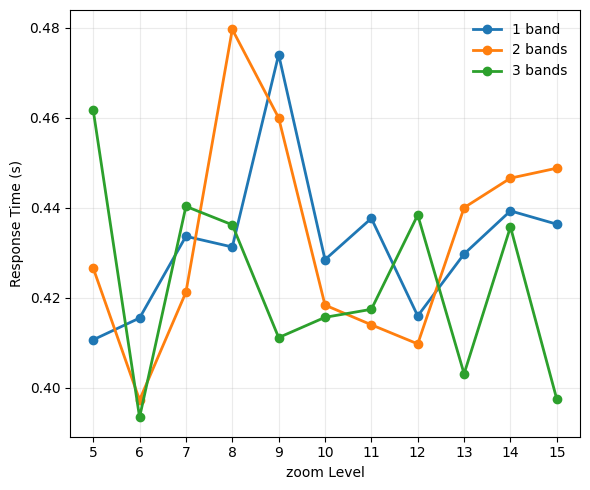

In [18]:
# --- plot all three lines together ---
fig, ax = plt.subplots(figsize=(6, 5))
for col in panel_df.columns:
    ax.plot(zoom_levels, panel_df[col].values, marker="o", linewidth=2, label=col)

ax.set_xticks(zoom_levels)  # exact zoom values
ax.set_xlabel("zoom Level")
ax.set_ylabel("Response Time (s)")
ax.grid(True, alpha=0.25)

fig.subplots_adjust(right=0.78)
ax.legend(frameon=False, loc="best")

plt.tight_layout()
plt.show()

## Conclusion

In this notebook, we explored how to check the performance of tile rendering performance in TiTiler-CMR using different datasets and backends. We observed how factors such as zoom levels, temporal intervals, and dataset structures impact the latency of tile requests.

In general, for either backend, performance depends on:
1. A dataset's spatial characteristics, specifically the resolution and granule-level spatial extent, impact performance at different zoom levels.
2. A dataset's temporal resolution impacts performance for different datetime intervals.

For the `rasterio` backend:
- Band selection does not impact performance because of titiler-cmr concurrency CHECK THIS

Takeaways: 

Use this tool to assess datasets of interest. If performance is poor, consider restricting applications use of the API to higher (more zoomed in) zoom levels and narrowing time frames.

### Further Reading
- [TiTiler-CMR GitHub Repository](https://github.com/developmentseed/titiler-cmr)
- [Titiler-CMR API Documentation](https://staging.openveda.cloud/api/titiler-cmr/api.html#/)
- [Tile Matrix Sets and Zoom Levels](https://docs.opengeospatial.org/is/17-083r2/17-083r2.html#_tile_matrix_sets_and_zoom_levels)
- [Earthdata Cloud CMR Datasets](https://cmr.earthdata.nasa.gov/search/site/docs/search/api.html#datasets)
